<a href="https://colab.research.google.com/github/LeninGF/CoursesNotes/blob/main/MarkovRL/03-blackJack-MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black Jack
- Estudiante: Lenin G. Falconi
## objetivos
- Explorar Muestreo de Importancia
- Explorar inicios que exploran

## Mecánica del Juego
- Dos partes: jugador y dealer
- La suma de cartas debe ser $\leq 21$
- Gana el que este más cerca de 21
- Empates: misma cantidad
- Recompensas:
    - si el jugador gana, +1
    - si empata, 0
    - si pierde, -1
- acciones: `[pedir cartas, plantar]`

## Cartas:
- 1 a 10 vale 1 a 10
- J, Q, K vale 10
- A vale 1 o 11 (estrategia)
- As es *útil* si se usa como 11. Se usará un boolean `as_util` que identifica si el *As* vale 11
## Ejemplo:
- Cadena de estados: 2 A 3 A 9 K
- `2+11=13`
- `13+3=16`
- `16+11=27-10` considero al inicial como 1 porque la suma se pasa de 21
- `17+9 = 26-10` el otro *As* se vuelve 1
- `16+10 = 26`, perdí
## Programa Dealer
- Tiene una política fija
- acciones: pedir carta mientras $\leq 17$
- se planta si $suma \geq 17$
- Cartas se reemplazan para el juego.... vuelven todas ..... no se quedan fuera algunas. Esto es para prevenir el conteo o memorización i.e. que el agente se vuelva bueno contando cartas y no enfrentando las condiciones del juego.

- **acciones:** pedir, plantar
- **estado:**`[cartas del jugador, la carta del lider, as_util]`
- $\gamma = 1$,
- $G = \sum R$ el retorno es la suma de recompensas

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Acciones

In [16]:
ACCION_PEDIR = 0
ACCION_PLANTAR = 1
ACCIONES = [ACCION_PEDIR, ACCION_PLANTAR]

## Política Dealer

In [17]:
POLITICA_DEALER = np.zeros(22) # cuantas sumas posibles hay
for i in range(12,17):
    POLITICA_DEALER[i] = ACCION_PEDIR
for i in range(17,22):
    POLITICA_DEALER[i] = ACCION_PLANTAR

## Política Jugador

- Se usará metodos dentro y fuera de política
- hallar la política deseada óptima

In [18]:
POLITICA_JUGADOR = np.zeros(22, dtype=np.int64)
for i in range(12,20):
    POLITICA_JUGADOR[i]= ACCION_PEDIR
POLITICA_JUGADOR[20] = ACCION_PLANTAR
POLITICA_JUGADOR[21] = ACCION_PLANTAR

## Estructura de la función para la política objetivo del jugador

In [19]:
def politica_objetivo_jugador(as_util_jugador, suma_jugador, carta_dealer):
    return POLITICA_JUGADOR[suma_jugador]

## Estructura de la funcion para la politica de comportamiento del jugador
- Revisar distribución binomial que simula a la moneda
### Distribución Binomial
- Cuenta el número de éxitos al realizar una serie de experimentos dicotómicos e independientes
- **Ensayo de Bernoulli:** es un experimento que tiene dos posibles resultados. La probabilidad de éxito es `p`, la de fracso es $q=1-p$. El número total de experímentos es $n$ y $p$ es la probabilidad de éxito de cada experimento:

$X \approx Bin(n,p)$

$P(X = x) = \binom{n}{x} p^x (1-p)^{n-x}$

$\binom{n}{x}$ es el número de formas de elegir $x$ elementos de un conjunto de $n$

$\binom{n}{x}=\frac{n!}{x!(n-x)!}$

In [20]:
def politica_comportamiento_jugador(as_util_jugador, suma_jugador, carta_dealer):
    if np.random.binomial(1,0.5)==1:
        return ACCION_PLANTAR
    return ACCION_PEDIR

## Pedir carta

acción fija del entorno
1 al 10 , jqk


In [21]:
def pedir_carta():
    carta = np.random.randint(1,14)
    # jqk se pasan a 10
    carta = min(carta, 10)
    return carta

## Valor de la carta

In [22]:
def valor_carta(carta_id):
    return 11 if carta_id ==1 else carta_id

## Función Jugar
Da las trayectorias y acciones que se siguen
IN:

- política de jugador
- estado inicial
- acción inicial

OUT:
- cadena de estados que ocurrieron durante el juego i.e. trayectoria de estados

In [23]:
def jugar(politica_jugador, estado_inicial=None, accion_inicial=None):
    # estatus del jugador
    suma_jugador = 0
    trayectoria_jugador = []
    as_util_jugador = False
    # estatus del dealer
    carta1_dealer = 0
    carta2_dealer = 0
    as_util_dealer = False
    ###### initialización del primer estado
    # generar estado inicial si no es dado
    if estado_inicial is None:
        while suma_jugador < 12:
            carta = pedir_carta()
            suma_jugador += valor_carta(carta)
            if suma_jugador > 21:
                assert suma_jugador == 22
                suma_jugador -= 10
            else:
                as_util_jugador |= (1==carta)
        carta1_dealer = pedir_carta()
        carta2_dealer = pedir_carta()
    # empezar el juego desde un estado inicial dado
    else:
        as_util_jugador, suma_jugador, carta1_dealer = estado_inicial
        carta2_dealer = pedir_carta()
    estado = [as_util_jugador, suma_jugador, carta1_dealer]
    # Iniciar la mano del dealer
    suma_dealer = valor_carta(carta1_dealer) + valor_carta(carta2_dealer)
    as_util_dealer = 1 in (carta1_dealer, carta2_dealer)
    # comprobar si la suma pasa de 21
    if suma_dealer > 21:
        assert suma_dealer == 22
        suma_dealer -= 10
    assert suma_dealer <= 21
    assert suma_jugador <= 21
    # #################
    # empezar el juego
    # #################
    # Turno del jugador
    while True:
        if accion_inicial is not None:
            accion = accion_inicial
            accion_inicial = None
        else:
            accion = politica_jugador(as_util_jugador, suma_jugador, carta1_dealer)
        # almacenar la trayectoria para utilizar MC y Muestreo de importancia
        trayectoria_jugador.append([(as_util_jugador, suma_jugador, carta1_dealer), accion]) # checar vid
        if accion == ACCION_PLANTAR:
            break
        carta = pedir_carta()
        # código para contar el número de As usables en la mano
        # el boolean as_util solo me dice si es usado como 1 o no
        contar_as = int(as_util_jugador)
        if carta == 1:
            contar_as+=1
        # Decidimos si usar nuestro As como 11 o uno
        suma_jugador += valor_carta(carta)
        while suma_jugador > 21 and contar_as:
            suma_jugador -= 10
            contar_as-=1
        # Jugador Pierde
        if suma_jugador > 21:
            return estado, -1, trayectoria_jugador
        # si no pierdo voy a turno del dealer
        assert suma_jugador <=21
        as_util_jugador = (contar_as==1)
    # ###########################################
    # Turno del dealer
    # ###########################################
    while True:
        accion = POLITICA_DEALER[suma_dealer]
        if accion == ACCION_PLANTAR:
            break
        otra_carta = pedir_carta()
        contar_as = int(as_util_dealer)
        if otra_carta == 1:
            contar_as +=1
        suma_dealer +=valor_carta(otra_carta)
        while suma_dealer > 21 and contar_as:
            suma_dealer -=10
            contar_as -=1
        if suma_dealer > 21:
            return estado, 1, trayectoria_jugador
        as_util_dealer = (contar_as == 1)
    # en caso de que ninguno pierda comparamos para finalizar la mano i.e. el episodio
    assert suma_jugador <= 21 and suma_dealer <=21
    if suma_jugador > suma_dealer:
        return estado, 1, trayectoria_jugador
    elif suma_jugador == suma_dealer:
        return estado, 0, trayectoria_jugador
    else:
        return estado, -1, trayectoria_jugador
    # return estado, 0, trayectoria_jugador # commentar es recomendacin de colab



## Montecarlo con inicios que exploran

- ¿por qué la dimension $10\times 10\times 2\times 2$? es un conteo de accion - estado
- hace evaluación y control
- Evaluación es la Predicción $V{\pi}(s_t)\doteq \mathbb{E}_{\pi}\left[R_{t+1}+\gamma V_{\pi}(S_{t+1})|S_t=s \right]$ (aplicar la Ecuación de Bellman). Es decir: $V_{k+1} = \sum_a \pi(a|s)\sum_{s',r}P(s',r|s,a)[r+\gamma V_k(s')]$
- La evaluación puede serÑ
    - Síncrona
    - En su lugar
- Mejorar la política es en cada iteración obtener una nueva mejor política $\pi_* =\text{greedy}(V_{\pi})$
- `contar_pares_estado_accion = np.ones((10,10,2,2))` cuenta cuántas veces un estado determinado

In [ ]:
def monte_carlo_es(episodios):
    valores_estado_accion = np.zeros((10,10,2,2)) # (suma_jugador, carta_dealer, as_util, accion)
    contar_pares_estado_accion = np.ones((10,10,2,2)) # empezamos en 1, evadir division para 0
    # se actualiza montecarlo con greedy
    # politica greedy montecarlo con ES se actualiza con greedy
    # montecarlo hace evaluacion y control
    def politica_comportamiento(as_util, suma_jugador, carta_dealer):
        # no me agrada una funcion dentro de otra funcion. ¿se podria escribir mejor?
        # contar pares de estado pasa a esta funcion por que ya existe en la funcion padre
        as_util = int(as_util)
        suma_jugador -=12
        carta_dealer -= 1  # porque estos decrementos?
        # obtener media de los valores
        valores_ = valores_estado_accion[suma_jugador, carta_dealer, as_util, :]/\
            contar_pares_estado_accion[suma_jugador, carta_dealer, as_util, :]
        # se devuelve valor que ha dado el máximo por cada estado
        # random choice rompe empates de manera aleatoria
        # es una politica greedy por eso me devuelve el maximo i.e. la accion que ha dado el valor maximo
        return np.random.choice([accion_ for accion_, valor_ in enumerate(valores_) if valor_ == np.max(valores_)])
    # jugar una cantidad de episodios para visualizar las iteraciones
    for episodio in tqdm(range(episodios)):
        # para cada episodio empezamos con un (estado/acción) random:
        estado_inicial = [bool(np.random.choice([0,1])),
                          np.random.choice(range(12,22)),
                          np.random.choice(range(1,11))]
        accion_inicial = np.random.choice(ACCIONES)
        # se usa política de comportamiento cuando hay episodios sino se inicia con la política objetivo/comportamiento
        # esta discrepancia en la explicacion se da en el 07:21 +/-
        # en el video hace referencia a usar la politica_comportamiento jugadir i.e:

        # politica_actual = politica_comportamiento if episodio else politica_comportamiento_jugador
        # pero esta escrito: 
        politica_actual = politica_comportamiento if episodio else politica_objetivo_jugador
        _, recompensa, trayectoria = jugar(politica_actual, estado_inicial, accion_inicial) # type: ignore
        check_primera_visita = set() # acumulo que estados y acciones ya se vieron i.e. entraron por primera vez
        for (as_util, suma_jugador, carta_dealer), accion in trayectoria:
            as_util = int(as_util)
            suma_jugador -= 12
            carta_dealer -= 1
            estado_accion = (as_util, suma_jugador, carta_dealer, accion)
            if estado_accion in check_primera_visita: # el estado ya se visito. No visito mas
                continue
            # agrego al conjunto si estado accion no esta en el conjunto
            check_primera_visita.add(estado_accion)
            # estamos con gamma = 1 por lo que no hay descuento
            valores_estado_accion[suma_jugador, carta_dealer, as_util, accion] += recompensa
            contar_pares_estado_accion[suma_jugador, carta_dealer, as_util, accion] += 1
    # promedio de los valores estado-accion
    return valores_estado_accion / contar_pares_estado_accion


## Montecarlo fuera de política

- Se pretende aprender la política óptima objetivo $\pi_*$ usando la experiencia de una política de comportamiento $b$
- Las políticas son distribuciones.
- la política $b$ puede y es greedy.
- $\rho$ razón de muestreo
- $\mathbb{E}_{\pi}[X] = \mathbb{E}_b[X\rho]$
- El muestreo de importancia normal es $V(s)\doteq \frac{\sum_{t\in \tau(s)}\rho_{t:T(t)-1}G_t}{|\tau(s)|}$ que divide para el número de veces. 
- El muestreo de importancia ponderado $V(s)\doteq \frac{\sum_{t\in \tau(s)}\rho_{t:T(t)-1}G_t}{\sum_{t\in \tau(s)}\rho_{t:T(t)-1}}$ que es dividido para la acumulacion de $\rho$

In [ ]:
def mc_fuera_politica(episodios):
    # usa el muestreo de importancia
    # quiero aprender mi politica objetivo a partir de una politica de comportamiento
    estado_inicial = [True, 13, 2] # as util, suma jugador, carta dealer
    rhos = [] # se acumula para hacer los cálculos
    retornos = []
    # se inicia con un poco de juego
    for i in range(0, episodios):
        # _ significa estado
        # politica de comportamiento es randomica a veces me planto a veces pido carta
        _, recompensa, trayectoria_jugador = jugar(politica_comportamiento_jugador,
                                                   estado_inicial=estado_inicial) # type: ignore
        # razón de importancia
        numerador = 1.0
        denominador = 1.0
        # para cada parte de la trayectoria ejecutar el cálculo de rhos
        for (as_util, suma_jugador, carta_jugador), accion in trayectoria_jugador:
            # la siguiente condicion se cumple si se cumple el requisito de cobertura
            # i.e. que las acciones que pasan en la politica objetivo tambien pasan en la politica de comportamiento
            if accion == politica_objetivo_jugador(as_util, suma_jugador, carta_jugador):
                # política objetivo jugador es determinista
                denominador *=0.5 # es 0.5 por la probabilidad que se puso 0.5 cara/sello pido/planto
            else:
                numerador = 0.0
                break
        rho = numerador/denominador
        rhos.append(rho)
        retornos.append(recompensa)
    rhos = np.asarray(rhos)
    retornos = np.asarray(retornos)
    # los retornos se han de multiplicar por los rhos para el muestreo ponderado y para el muestreo normal
    retornos_ponderados = rhos * retornos
    rhos = np.add.accumulate(rhos) # permite añadir y acumular
    retornos_ponderados = np.add.accumulate(retornos_ponderados) # tambien se esta la parte la sumatario para los retornos que estan multiplicados por rho
    # realizar el muestreo ordinario
    muestreo_ordinario = retornos_ponderados/np.arange(1,episodios+1) # se divide para el numero de veces i.e. numero de episodios
    # muestreo ponderado puede tener divisiones por 0
    # cuando rho sea 0 el resultado sera 0
    with np.errstate(divide='ignore', invalid='ignore'):
        # lo que se evita es la division por 0, si los rhos son 0s el cociente se asume 0, sino se hace la division
        muestreo_ponderado = np.where(rhos != 0, retornos_ponderados/rhos, 0)
    return muestreo_ordinario, muestreo_ponderado

## Funciones para graficar


In [26]:
def pol_val_mc_es():
    # montecarlo política inicios que exploran valores de estado
    valores_estado_accion = monte_carlo_es(500000)
    # dos políticas 1. as útil y 0. no as útil
    # valores acción estado óptimos
    valores_estado_no_as_util = np.max(valores_estado_accion[:,:,0,:], axis=-1)
    valores_estado_si_as_util = np.max(valores_estado_accion[:,:,1,:], axis=-1)
    # política óptima
    # opengo la acción que me dio el mejor valor
    accion_no_as_util = np.argmax(valores_estado_accion[:,:,0,:],axis=-1)
    accion_si_as_util = np.argmax(valores_estado_accion[:,:,1,:],axis=-1)
    # Para graficar
    imagenes = [accion_si_as_util,
                valores_estado_si_as_util,
                accion_no_as_util,
                valores_estado_no_as_util]
    titulos = ["Politica optima con AS util",
               "valores optimos con AS Util",
               "POlitica Optima sin As Util",
               "valores Optimos sin As Util"]
    _, axes = plt.subplots(2,2,figsize=(40,30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for imagen, titulo, axis in zip(imagenes, titulos, axes):
        fig = sns.heatmap(np.flipud(imagen),
                          cmap="YlGnBu",
                          ax=axis,
                          xticklabels=range(1,11), # type: ignore
                          yticklabels=list(reversed(range(12,22)))) # type: ignore
        fig.set_ylabel('Suma del Jugador', fontsize=30)
        fig.set_xlabel('Mano del Dealer', fontsize=30)
        fig.set_title(titulo, fontsize=30)
    plt.show()
    plt.close()

Gráfica del muestreo ordinario vs el ponderado

In [27]:
def muestreo_ordinario_ponderado():
    valor_optimo = -0.277726  # este valor de dónde?
    episodios = 10000
    repeticiones = 100
    error_ordinario = np.zeros(episodios)
    error_ponderado = np.zeros(episodios)
    for i in tqdm(range(0, repeticiones)):
        muestreo_ordinario_, muestreo_ponderado_ = mc_fuera_politica(episodios=episodios)
        error_ordinario += np.power(muestreo_ordinario_ - valor_optimo,2)
        error_ponderado += np.power(muestreo_ponderado_ - valor_optimo,2)
    error_ordinario /= repeticiones
    error_ponderado /= repeticiones
    plt.plot(np.arange(1,episodios+1), error_ordinario, color='green', label='Muestreo de Importancia Ordinario')
    plt.plot(np.arange(1,episodios+1), error_ponderado, color='red', label='Muestreo de Importancia Ponderado')
    plt.ylim(-0.1,5)
    plt.xlabel('Episodios (escala logarítmica)')
    plt.ylabel(f'Error cuadratico promedio\n(promedio de {repeticiones} repeticiones)')
    plt.xscale('log')
    plt.legend()
    plt.show()
    plt.close()



## Ejecución

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [00:55<00:00, 9043.51it/s] 


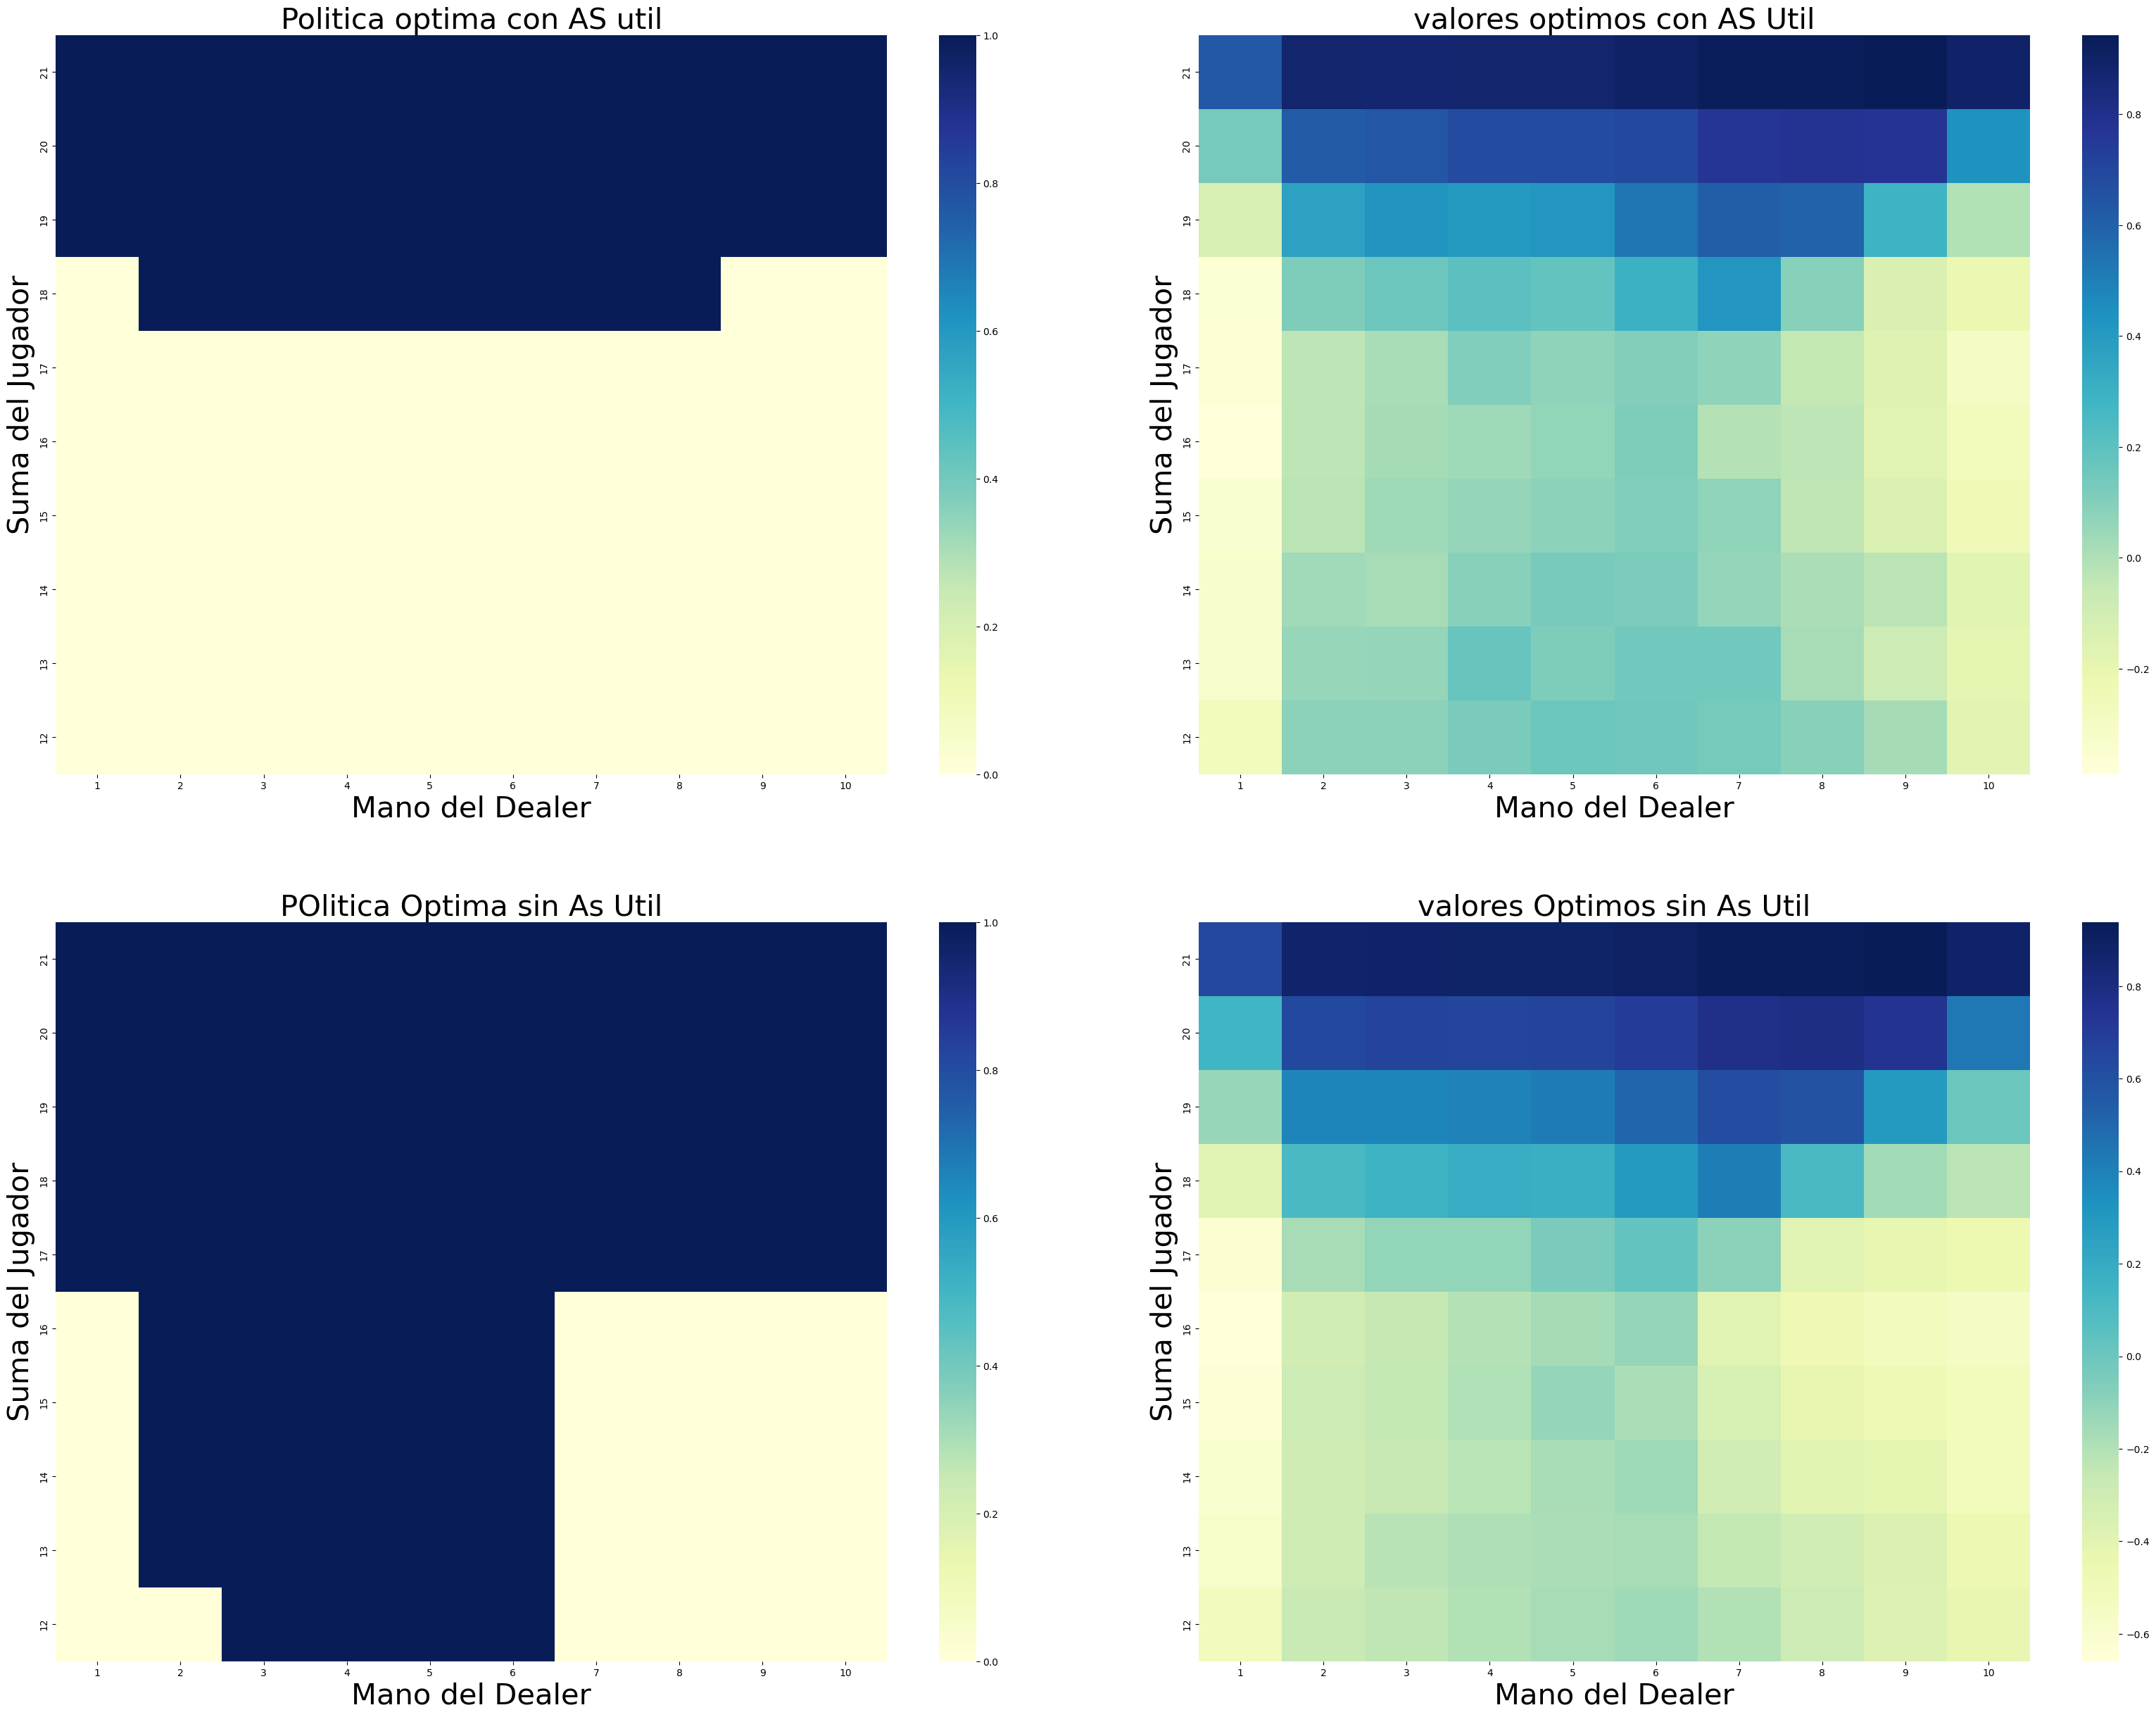

100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


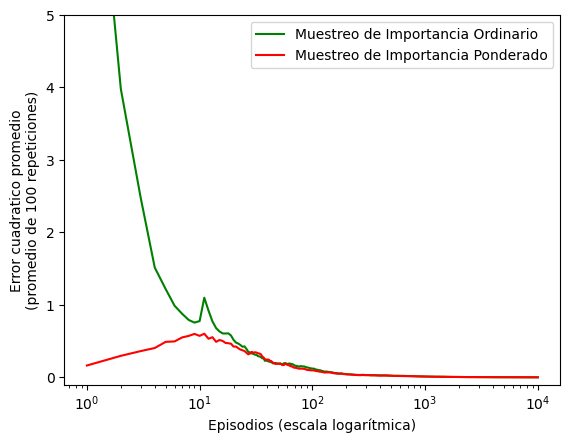

CPU times: total: 1min 18s
Wall time: 1min 18s


In [28]:
%%time
pol_val_mc_es()
muestreo_ordinario_ponderado()